In [26]:
import os
import zipfile
import shutil
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

import cv2
import numpy as np
from model import StereoCNN
from sa_model import BaselineStereoCNN, SegStereoCNN, SASegStereoCNN, BaselineStereoCNN2, SASegStereoCNN2, SegStereoCNN2
from tqdm import tqdm
from torchsummary import summary
import argparse
from dataset_kitti import StereoDataset
from transforms import transform_disparity_fn, transform_fn, test_transform_fn

In [27]:
DATASET_FOLDER = "data/kitti2015/data_scene_flow"

(375, 1242, 3)


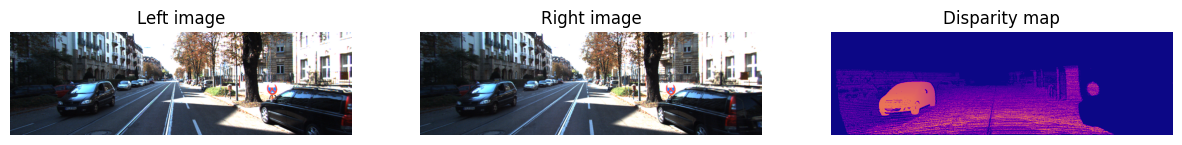

In [28]:
# load an image from the KITTI2015 data set located at /data/kitti2015/training/image_2/000000_10.png

import cv2
import numpy as np

# load image
img = cv2.imread(f'{DATASET_FOLDER}/training/image_2/000000_10.png')

# load right image
img_r = cv2.imread(f'{DATASET_FOLDER}/training/image_3/000000_10.png')

# load disparity map
disp = cv2.imread(f'{DATASET_FOLDER}/training/disp_noc_0/000000_10.png', cv2.IMREAD_UNCHANGED)

print(img.shape)

# display left and right image and disparity map side by side using matplotlib

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].set_title('Left image')
ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(img_r, cv2.COLOR_BGR2RGB))
ax[1].set_title('Right image')
ax[1].axis('off')
ax[2].imshow(disp, cmap='plasma')
ax[2].set_title('Disparity map')
ax[2].axis('off')

plt.show()






In [29]:
transform = transform_fn()
transform_disparity = transform_disparity_fn()
test_transform = test_transform_fn()

In [30]:
def show_disparity(target_model, left_img, right_img, disparity_map, title='baseline'):
    # load left and right images
    orig_left_image = cv2.imread(left_img)
    orig_right_img = cv2.imread(right_img)

    if disparity_map is not None:
        orig_ground_truth_disparity = cv2.imread(disparity_map, cv2.IMREAD_GRAYSCALE)
        # resize
        orig_ground_truth_disparity = cv2.resize(orig_ground_truth_disparity, (879, 400))

        # enhance disparity map by making its histogram equalized
        orig_ground_truth_disparity = cv2.equalizeHist(orig_ground_truth_disparity)

            
    # resize images
    orig_left_image = cv2.resize(orig_left_image, (879, 400))
    orig_right_img = cv2.resize(orig_right_img, (879, 400))

    target_model.eval()

    with torch.no_grad():
        disparity, left_mask = target_model.inference(orig_left_image, orig_right_img)
        disparity_plt = disparity.squeeze().cpu().numpy()

        # enhance disparity map by making its histogram equalized
        disparity_plt = (disparity_plt - disparity_plt.min()) / (disparity_plt.max() - disparity_plt.min())
        disparity_plt = disparity_plt * 255

        # black out the upper part 1/4 of the disparity map
        disparity_plt[:45, :] = 0

        # display side-by-side using matplotlib
        fig, axs = plt.subplots(2, 3, figsize=(30, 10))
        left_img_plt = orig_left_image

        axs[0][0].imshow(left_img_plt)
        axs[0][0].set_title('Left Image')
        axs[0][1].imshow(disparity_plt, cmap='plasma')
        axs[0][1].set_title('Predicted Disparity')
        axs[0][2].imshow(orig_ground_truth_disparity, cmap='plasma')
        axs[0][2].set_title('Ground Truth Disparity')
        axs[1][0].set_visible(False)
        axs[1][1].set_visible(False)
        axs[1][2].set_visible(False)
        
        if not os.path.exists('test_images'):
            os.makedirs('test_images')
        # save these images for later
        cv2.imwrite(f'test_images/{title}_left_image.png', orig_left_image)
        cv2.imwrite(f'test_images/{title}_disparity.png', disparity_plt)
        cv2.imwrite(f'test_images/{title}_ground_truth_disparity.png', orig_ground_truth_disparity)
        
        if left_mask is not None:
            # rearrange for matplotlib
            left_mask_plt = left_mask.squeeze().cpu().numpy()
            left_mask_plt = left_mask_plt.transpose((1, 2, 0))
            axs[1][0].imshow(left_mask_plt)
            axs[1][0].set_title('Segmentation Mask')
            axs[1][0].set_visible(True)
            cv2.imwrite(f'test_images/{title}_left_mask.png', left_mask_plt * 255)
        plt.show()

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
model = BaselineStereoCNN(device)
model.to(device)
if os.path.exists('stereo_cnn_stereo_cnn_baseline_ktti.pth'):
    print("loading existing checkpoint ...")
    checkpoint = torch.load('stereo_cnn_stereo_cnn_baseline_ktti.pth')
    model.load_state_dict(checkpoint)


loading existing checkpoint ...


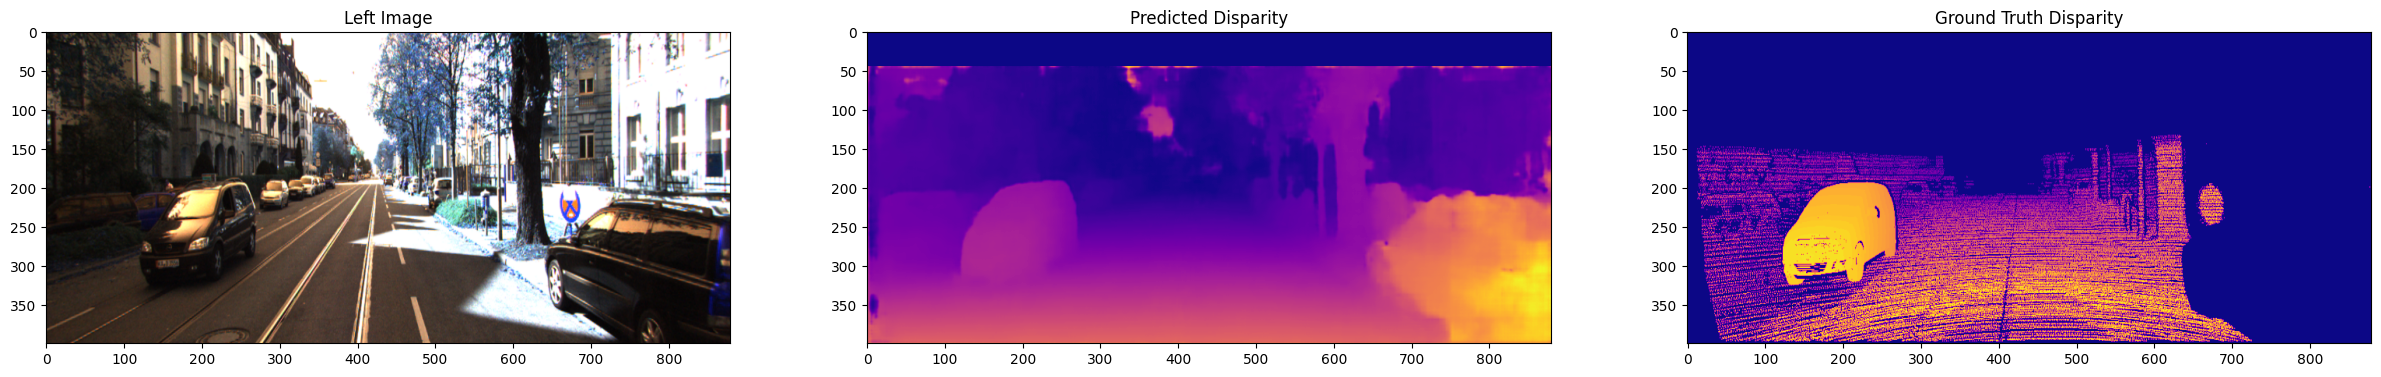

In [33]:
show_disparity(model, f'{DATASET_FOLDER}/training/image_2/000000_10.png', f'{DATASET_FOLDER}/training/image_3/000000_10.png', f'{DATASET_FOLDER}/training/disp_noc_0/000000_10.png', 'kitti')
